In [2]:
%matplotlib inline


# Blockmodel


Example of creating a block model using the quotient_graph function in NX.  Data
used is the Hartford, CT drug users network::

    @article{weeks2002social,
      title={Social networks of drug users in high-risk sites: Finding the connections},
      url = {https://doi.org/10.1023/A:1015457400897},
      doi = {10.1023/A:1015457400897},
      author={Weeks, Margaret R and Clair, Scott and Borgatti, Stephen P and Radda, Kim and Schensul, Jean J},
      journal={{AIDS and Behavior}},
      volume={6},
      number={2},
      pages={193--206},
      year={2002},
      publisher={Springer}
    }


In [5]:
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy
import urllib
from scipy.cluster import hierarchy
from scipy.spatial import distance

In [6]:
url = "https://dl.dropboxusercontent.com/s/iahhn4yir36sy3q/hartford_drug.edgelist?dl=1"
with urllib.request.urlopen(url) as f:
    data = f.read().decode('utf-8')
with open('hartford_drug.edgelist', 'w') as f:
    f.write(data) 

In [7]:
def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length = nx.all_pairs_shortest_path_length(G)
    distances = numpy.zeros((len(G), len(G)))
    for u, p in path_length:
        for v, d in p.items():
            distances[u][v] = d
    # Create hierarchical cluster
    Y = distance.squareform(distances)
    Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership = list(hierarchy.fcluster(Z, t=1.15))
    # Create collection of lists for blockmodel
    partition = defaultdict(list)
    for n, p in zip(list(range(len(G))), membership):
        partition[p].append(n)
    return list(partition.values())

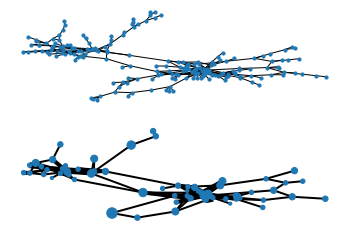

In [8]:
G = nx.read_edgelist("hartford_drug.edgelist")
# Extract largest connected component into graph H
H = G.subgraph(next(nx.connected_components(G)))
# Makes life easier to have consecutively labeled integer nodes
H = nx.convert_node_labels_to_integers(H)
# Create parititions with hierarchical clustering
partitions = create_hc(H)

# Build blockmodel graph
BM = nx.quotient_graph(H, partitions, relabel=True)

# Draw original graph
pos = nx.spring_layout(H, iterations=100)
plt.subplot(211)
nx.draw(H, pos, with_labels=False, node_size=10)

# Draw block model with weighted edges and nodes sized by number of internal nodes
node_size = [BM.nodes[x]['nnodes'] * 10 for x in BM.nodes()]
edge_width = [(2 * d['weight']) for (u, v, d) in BM.edges(data=True)]
# Set positions to mean of positions of internal nodes from original graph
posBM = {}
for n in BM:
    xy = numpy.array([pos[u] for u in BM.nodes[n]['graph']])
    posBM[n] = xy.mean(axis=0)
plt.subplot(212)
nx.draw(BM, posBM, node_size=node_size, width=edge_width, with_labels=False)
plt.axis('off')
plt.show()